In [1]:
# Temporary import. It will be removed in the final vserion
import os
import sys

import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from pytagi import exponential_scheduler
from pytagi.nn import LSTM, Linear, Sequential
from pytagi.LSTM_KF_RL_Env import LSTM_KF_Env

from examples.data_loader import TimeSeriesDataloader, SyntheticTimeSeriesDataloader
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm

from itertools import count
import random

In [2]:
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

# Network
net = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net.set_threads(8)
net.load(filename='./saved_param/HQ_hybrid_LSTM/lstm_hq_hybrid_onlydisp4.pth')
# #net.to_device("cuda")

# # State-space models: for baseline hidden states
phi_AA = 0.997
Sigma_AR = 0.11453**2
phi_AR = 0.51824134
Sigma_AA = Sigma_AR*1e-16
LA_var_stationary = Sigma_AA /(1-phi_AA**2)
AR_var_stationary = Sigma_AR /(1-phi_AR**2)
# Autoregressive acceleration + online AR
# hybrid = LSTM_SSM(
#     neural_network = net,           # LSTM
#     baseline = 'AA + AR', # 'level', 'trend', 'acceleration', 'ETS'
#     zB  = np.array([0.1, 1E-4, 0, 0.51824134, 0.02]),    # initial mu for baseline hidden states
#     SzB = np.array([1E-5, 1E-8, LA_var_stationary, 1E-16, Sigma_AR]),    # var
#     phi_AA = phi_AA,
#     Sigma_AR = Sigma_AR,
#     Sigma_AA = Sigma_AA,
# )
hybrid = LSTM_SSM(
    neural_network = net,           # LSTM
    baseline = 'AA + plain_AR', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = np.array([0.1, 1E-4, 0, 0.02]),    # initial mu for baseline hidden states
    SzB = np.array([1E-5, 1E-8, LA_var_stationary, AR_var_stationary]),    # var
    phi_AA = phi_AA,
    phi_AR = phi_AR,
    Sigma_AR = Sigma_AR,
    Sigma_AA = Sigma_AA,
    use_online_AR=False,
)
ts_mean = np.array([1.0649368, 26.64127424])
ts_std = np.array([1.0880665, 14.98919694])

random_column = random.randint(0, 19)

In [3]:
# Get initial state from a stationary synthetic time series
# train_dtl = TimeSeriesDataloader(
#     x_file="data/HQ/hq_ts2.csv",
#     date_time_file="data/HQ/hq_ts2_datetime.csv",
train_dtl = SyntheticTimeSeriesDataloader(
    # x_file="data/HQ/syn_dataset_hqts2_lstm_unstandardized_20episodes.csv",
    # select_column = 7,
    x_file="data/HQ/syn_dataset_hqts2_lstm_unstandardized_model4_ts1.csv",
    date_time_file="data/HQ/syn_dataset_hqts2_lstm_datetime.csv",
    x_mean=ts_mean,
    x_std=ts_std,
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
)
env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl, \
                            ts_model=hybrid, step_look_back=8)
state, _ = env.reset()

for t in count():
    action = 0
    state, reward, terminated, _, info = env.step(action)

    if terminated:
        break

In [4]:
# train_dtl = TimeSeriesDataloader(
#     x_file="data/HQ/hq_ts2.csv",
#     date_time_file="data/HQ/hq_ts2_datetime.csv",
train_dtl = SyntheticTimeSeriesDataloader(
    # x_file="data/HQ/syn_dataset_hqts2_lstm_unstandardized_20episodes.csv",
    # select_column = 7,
    x_file="data/HQ/syn_dataset_hqts2_lstm_unstandardized_model4_ts1.csv",
    date_time_file="data/HQ/syn_dataset_hqts2_lstm_datetime.csv",
    # add_anomaly = True,
    # anomaly_magnitude=-0.002,
    # anomaly_start=300,
    x_mean=ts_mean,
    x_std=ts_std,
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
)

In [5]:
env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl, \
                            ts_model=hybrid, step_look_back=8)
state, _ = env.reset(z=env.ts_model.z, Sz=env.ts_model.Sz)

for t in count():
    action = 0
    state, reward, terminated, _, info = env.step(action)

    if terminated:
        break

In [6]:
mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()

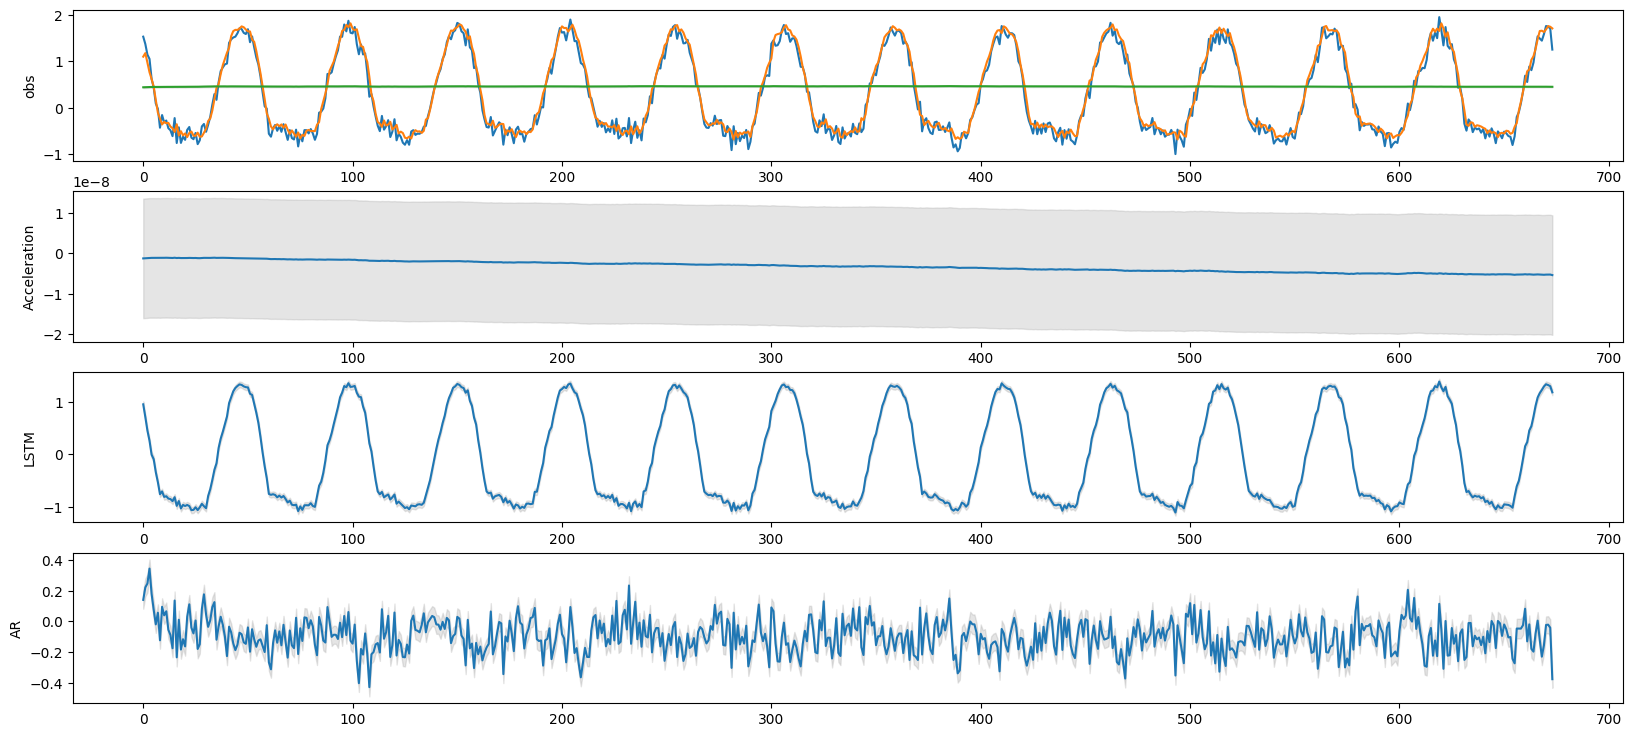

In [7]:
# Plot prediction
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(4, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

time_step_indices = np.arange(0, len(mu_hidden_states_one_episode[:,2]), 1)

# Plot prediction
ax0.plot(time_step_indices, info['measurement_one_episode'], label='Observation')
ax0.plot(time_step_indices, mu_prediction_one_episode, label='Prediction')
# ax0.fill_between(
#     time_step_indices,
#     mu_prediction_one_episode - np.sqrt(var_prediction_one_episode),
#     mu_prediction_one_episode + np.sqrt(var_prediction_one_episode),
#     alpha=0.2,
#     color='gray',
# )
ax0.plot(time_step_indices, mu_hidden_states_one_episode[:,0], label='LL hidden state')
ax0.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),
    mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]),
    alpha=0.2,
    color='gray',
)
ax0.set_ylabel('obs')
# ax0.set_title('Synthetic time series')

# Plot AA hidden states
ax1.plot(time_step_indices, mu_hidden_states_one_episode[:,2], label='AA hidden state')
ax1.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),
    mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]),
    alpha=0.2,
    color='gray',
)
# ax1.set_ylim(-3e-8,1e-8)
ax1.set_ylabel('Acceleration')

# Plot LSTM hidden states
ax2.plot(time_step_indices, mu_hidden_states_one_episode[:,-1], label='LSTM hidden state')
ax2.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),
    mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]),
    alpha=0.2,
    color='gray',
)
ax2.set_ylabel('LSTM')

# Plot AR hidden states
ax3.plot(time_step_indices, mu_hidden_states_one_episode[:,-2], label='AR hidden state')
ax3.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    alpha=0.2,
    color='gray',
)
ax3.set_ylabel('AR')
# ax3.set_ylim(-0.4,0.2)

plt.show()

In [8]:
# Load AR from 'saved_results/retrain_syn/AR.json'
import json
with open('saved_results/retrain_syn/retrain_AR.json', 'r') as f:
    AR_2 = json.load(f)

mu_AR2 = np.array(AR_2['mu_ar'])
var_AR2 = np.array(AR_2['var_ar'])

In [9]:
# Load AR from 'saved_results/retrain_syn/AR.json'
import json
with open('saved_results/retrain_syn/true_AR.json', 'r') as f:
    true_AR = json.load(f)

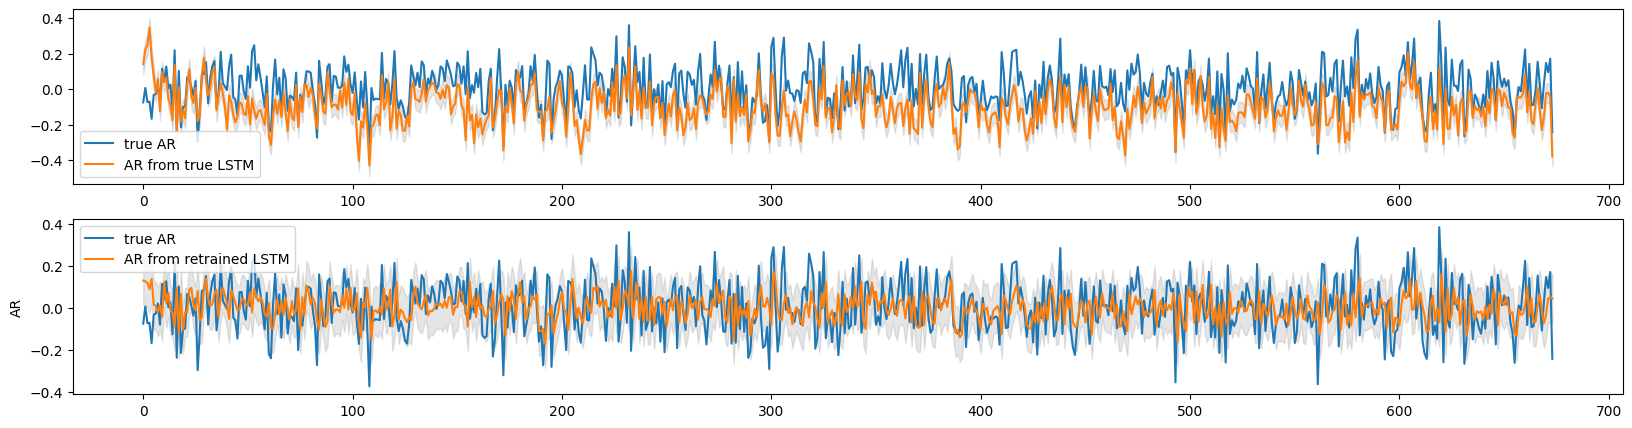

In [13]:
# Plot AR2 and mu_hidden_states_one_episode[:,-2] together in one figure
fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

time_step_indices = np.arange(0, len(mu_hidden_states_one_episode[:,2]), 1)
# time_step_indices2 = np.arange(0, len(mu_AR2), 1)
ax0.plot(time_step_indices, true_AR[26:], label='true AR')

ax0.plot(time_step_indices, mu_hidden_states_one_episode[:,-2], label='AR from true LSTM')
ax0.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    alpha=0.2,
    color='gray',
)
ax0.legend()


ax1.plot(time_step_indices, true_AR[26:], label='true AR')

ax1.plot(time_step_indices, mu_AR2, label='AR from retrained LSTM')
ax1.fill_between(
    time_step_indices,
    mu_AR2 - np.sqrt(var_AR2),
    mu_AR2 + np.sqrt(var_AR2),
    alpha=0.2,
    color='gray',
)
ax1.set_ylabel('AR')
ax1.legend()
plt.show()